In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Application de la méthode de Galerkine aux données
"""

#DataFolder="C:/Users/Julie_000/Desktop/Stage/Stage_l3"
DataFolder="E:/Clément/Julie/Stage_L3"

In [2]:
from mat4py import loadmat #pour charger des .mat
import matplotlib
import matplotlib.pyplot as plt # pour tracer les figures
import os # pour modifier le dossier de travail
import numpy as np 
from pathlib import Path # Pour rendre les Path compatibles entre Mac et Windows
from matplotlib import rc #Les trois prochaines lignes pour que Ã§a ressemble Ã  latex
rc('font', size=16)
rc('text', usetex=True)
import scipy as sc
import matplotlib.cm as cm #colormaps
from matplotlib.colors import Normalize #Pour l'utilisation des couleurs dans quiver
from matplotlib.ticker import MaxNLocator #pour les courbes de niveau
from scipy.ndimage import gaussian_filter #Filtrage gaussien
import matplotlib.patches as mpatches #pour le nageur

from scipy.linalg import pinv as scpinv
from numpy.linalg import pinv as nppinv


from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

import fonctions_projet_divergence as fpd#pour les données

colormap2=cm.PiYG#colormap

from mpl_toolkits.mplot3d import Axes3D#plot3D

In [63]:
def PIV(prof,manips): 
    """retourne les données des plans pour la bonne profondeur"""
    if prof==5:
        piv=manips['piv5']
    elif prof==10:
        piv=manips['piv10']
    elif prof==15:
        piv=manips['piv15']
    else:
        return("prof n'a pas une valeur acceptable")   
    return(piv)

def nb_plan(prof):
    "Détermine le nombre de plan pour une profondeur donnée"
    if prof==5:
        return(16)
    if prof==10:
        return(32)
    if prof==15:
        return(49)
    else:
        return("prof n'a pas une valeur acceptable")
    
def donnees(n,piv,size):
    "Charge les données pour la profondeur donnée"
    u=np.zeros((n,size,size))
    v=np.zeros((n,size,size))
    x=np.zeros((n,size,size))
    y=np.zeros((n,size,size))
    z=np.zeros((n))

    for plan in range(n): 
            u[plan]=np.array(piv[plan]['u'])
            v[plan]=np.array(piv[plan]['v'])
            x[plan]=np.array(piv[plan]['x'])
            y[plan]=np.array(piv[plan]['y'])
            z[plan]=np.array(piv[plan]['prof'])
    return(u,v,x,y,z)

def conv(u,plan,variable_fixe):
    "Met les array sous la bonne forme"
    if np.ndim(u)==3:
        if variable_fixe=='x':
            return(np.transpose(u[:,:,plan]))
        elif variable_fixe=='y':
            return(np.transpose(u[:,plan,:]))
    elif np.ndim(u)==4:
        conv=np.zeros((np.shape(u)[0],size-1,P))
        if variable_fixe=='x':
            for i in range(np.shape(u)[0]):
                conv[i]=np.transpose(u[i,:,:,plan])
            return(conv)
        elif variable_fixe=='y':
            for i in range(np.shape(u)[0]):
                conv[i]=np.transpose(u[i,:,plan,:])
            return(conv)
        
def vitesse_nageur(prof):
    "donne la vitesse du nageur pour une profondeur. Elle est suivant ey"
    if prof==5:
        return(60)
    elif prof==10:
        return(59)
    elif prof==15:
        return(62)
    
    
def plot_champ_vitesse(u,v,x,y,title):
    "Fonction de tracé du champ de vitesse"
    #norme
    velocity=np.sqrt(u**2+v**2)
    velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
    colors = np.copy(velocity)
    colors[velocity>velmax]=velmax
    colormap=cm.magma#colormap je crois que cette commande ne fonctionne pas
    norm = Normalize()
    norm.autoscale(colors)

    #plot   
    fig,ax=plt.subplots(num=title)
    im=ax.quiver(x[::2,::2],y[::2,::2],u[::2,::2]/velocity[::2,::2],v[::2,::2]/velocity[::2,::2],colors[::2,::2])
    fig.colorbar(im, ax=ax)  #pour la barre de couleur
    
    fig.suptitle(title,fontsize=16)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    
    
def plot_divergence(div,dx,dy,title,vmin,vmax):
    "Tracé des divergences"
    #norme
    #dx=dx[20:80,30:90]
    #dy=dy[20:80,30:90]
    #div=div[20:80,30:90]
    norm=Normalize(vmin=vmin, vmax=vmax)
    levels = MaxNLocator(nbins=255).tick_values(vmin,vmax)
    
    fig, l0 = plt.subplots(num=title)
    im0 = l0.contourf(dx,dy,div,levels=levels, cmap=colormap2,norm=norm)
    fig.colorbar(im0,ax=l0)
    l0.set_xlabel('x')
    l0.set_ylabel('y')
    circle = mpatches.Circle((0,0), 6, color='snow')#patch
    l0.add_patch(circle)
   
    fig.tight_layout(pad = 3)
    fig.suptitle(title,fontsize=20)
    plt.show()
    
def divergence2D_astropy(u,v,x,y,sigma):
    "Applique le programme de divergence2D avec filtre gaussien sur la vitesse"
    unan=np.copy(u)
    vnan=np.copy(v)
    unan[u==0]=np.nan
    vnan[v==0]=np.nan
    #Filtrage
    # We smooth with a Gaussian kernel with x_stddev=1 (and y_stddev=1)
    # It is a 9x9 array
    kernel = Gaussian2DKernel(x_stddev=sigma,y_stddev=sigma)

    # astropy's convolution replaces the NaN pixels with a kernel-weighted
    # interpolation from their neighbors
    u_filtre = convolve(unan, kernel)
    v_filtre = convolve(vnan, kernel)

    
    #dérivation
    du_filtre,dv_filtre=fpd.deriv(u_filtre,x,1),fpd.deriv(v_filtre,y,0)
    dx=fpd.abcisse(x,1)
    dy=fpd.abcisse(y,0)
    #shape
    du_filtre,dv_filtre=fpd.good_shape(du_filtre),fpd.good_shape(dv_filtre)
    dx,dy=fpd.good_shape(dx),fpd.good_shape(dy)
    #somme
    div = fpd.somme(du_filtre,dv_filtre)
    #masque
    div_masque=fpd.masque(div,x,y,dx,dy)
    return(div_masque,dx,dy)

def methode_Galerkine_2(u,v,x,y,z,P,m,h):
    "Galerkine en ignorant les valeurs nulles"
    #divergence bidimensionelle
    div_2D=np.zeros((P,size-1,size-1))
    dx=np.zeros((P,size-1,size-1))
    dy=np.zeros((P,size-1,size-1))
    vz=np.zeros((P,size-1,size-1))
    dvz=np.zeros((P,size-1,size-1))

    for plan in range(P):
        div_2D[plan],dx[plan],dy[plan]=divergence2D_astropy(u[plan],v[plan],x[plan],y[plan],2)
    for i in range(size-1):
        for j in range(size-1):
            divij=div_2D[:,i,j]
            zcor=z[divij==divij] #False pour un NaN, True sinon
            divijcor=divij[divij==divij]
            pinv=nppinv(np.transpose(np.array([n*np.pi/h*np.cos(n*np.pi/h*zcor) for n in range(1,m+1)])))
            a=np.matmul(pinv,divijcor)
            sin=np.transpose(np.array([np.sin(n*np.pi*z/h) for n in range(1,m+1)]))
            dsin=np.transpose(np.array([n*np.pi/h*np.cos(n*np.pi*z/h) for n in range(1,m+1)]))

            a=np.reshape(a,(np.shape(a)[-1]))
            sin=np.reshape(sin,(np.shape(sin)[-2],np.shape(sin)[-1]))
            dsin=np.reshape(dsin,(np.shape(dsin)[-2],np.shape(dsin)[-1]))

            if len(zcor)>2*m:
                vz[:,i,j]=np.matmul(sin,a)
                dvz[:,i,j]=np.matmul(dsin,a)

    return(vz,dvz)

In [4]:
prof=15 # Choisi sur quelle profondeur d'eau travailler (5, 10 ou 15 mm)

In [5]:
os.chdir(Path(DataFolder)) # se place dans le dossier où est rangée la manip
manips=loadmat('PIVnagseulbis.mat') # Charge les données dans la variable manip

piv=PIV(prof,manips)#données pour la profondeur

P=nb_plan(prof)#nombre de plan dans la profondeur choisie
size=len(np.array(piv[0]['u']))

u0,v0,x0,y0,z=donnees(P,piv,size)
print(np.shape(u0),np.shape(v0),np.shape(x0),np.shape(y0),np.shape(z))

v_nageur=vitesse_nageur(prof)

(49, 120, 120) (49, 120, 120) (49, 120, 120) (49, 120, 120) (49,)


C:\Users\clement.gouiller\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide


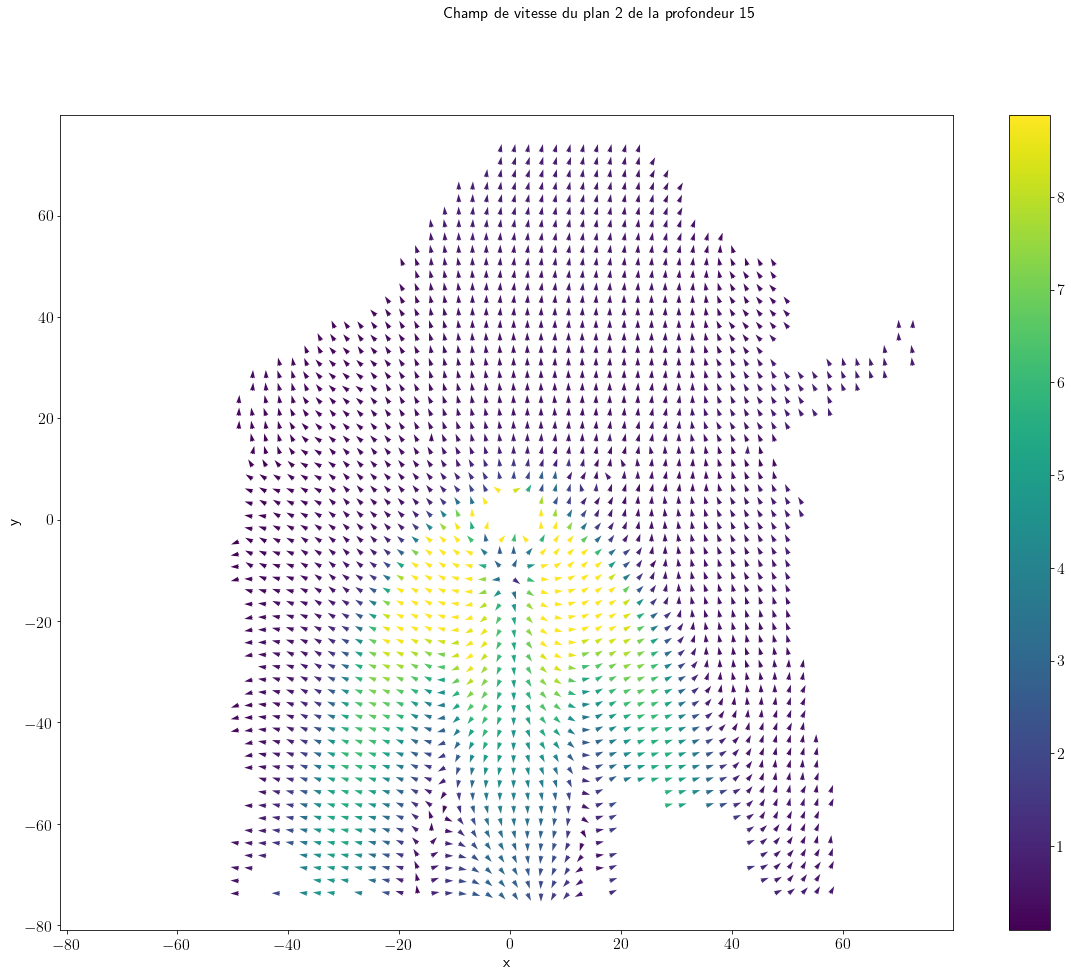

In [6]:
plt.rcParams['figure.figsize'] = [20, 15] # taille par défaut des figures qu'on trace

plan=2
plot_champ_vitesse(u0[plan],v0[plan],x0[plan],y0[plan],"Champ de vitesse du plan 2 de la profondeur 15")
plt.rcParams['figure.figsize'] = [8, 4.5] # taille par défaut des figures qu'on trace


In [22]:
div_2D=np.zeros((P,size-1,size-1))
dx=np.zeros((P,size-1,size-1))
dy=np.zeros((P,size-1,size-1))
div_2Db=np.zeros((P,size-1,size-1))
dxb=np.zeros((P,size-1,size-1))
dyb=np.zeros((P,size-1,size-1))

for plan in range(P):
    div_2D[plan],dx[plan],dy[plan]=divergence2D_astropy(u0[plan],v0[plan],x0[plan],y0[plan],1)
    div_2Db[plan],dxb[plan],dyb[plan]=divergence2D_astropy(u0[plan],v0[plan],x0[plan],y0[plan],1)

In [29]:
div_2D[div_2D!=div_2D]=0

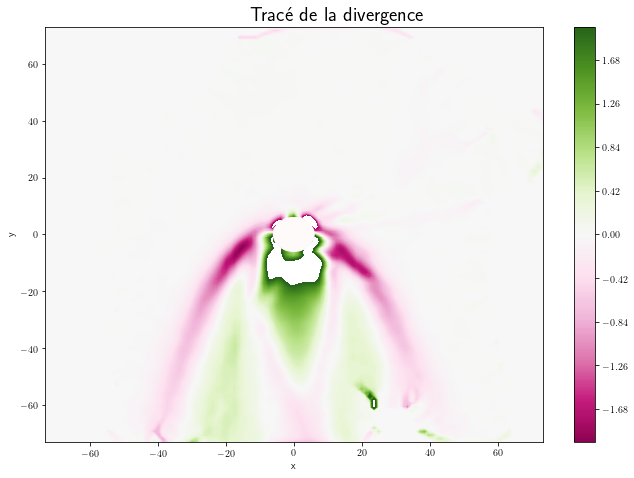

In [42]:
#%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 7] # taille par défaut des figures qu'on trace
plan=2
plot_divergence(div_2D[plan],dx[plan],dy[plan],"Tracé de la divergence",-2,2)
plt.rcParams['figure.figsize'] = [8, 4.5] # taille par défaut des figures qu'on trace


In [53]:
m=15

In [64]:
vz,dvz=methode_Galerkine_2(u0,v0,x0,y0,z,P,m,prof)


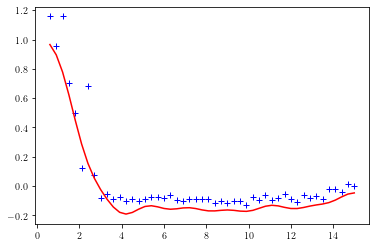

In [72]:
%matplotlib inline
i=36
j=60
divij=div_2D[:,i,j]
zcor=z[divij==divij] #False pour un NaN, True sinon
divijcor=divij[divij==divij]
plt.plot(zcor,divijcor,'+b',z,dvz[:,i,j],'-r')
plt.show()